# Import 

In [1]:
# Standard Libraries
import os
import shutil
import warnings 

# Data Handling & Processing
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning & Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array


2025-03-04 16:14:03.505702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-04 16:14:03.582802: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Data Cleaning 

In [2]:
# data origin: https://www.kaggle.com/datasets/safi842/highcarbon-micrographs/data
data = pd.read_excel('new_metadata.xlsx')
data.head()

path  anneal_temperature  anneal_time anneal_time_unit  \
0  micrograph2.png                 800           85                H   
1  micrograph4.png                 970           90                M   
2  micrograph5.png                 750            5                M   
3  micrograph6.png                 970           90                M   
4  micrograph7.png                 970           90                M   

  cool_method magnification   primary_microconstituent  
0           Q         1964X                spheroidite  
1          FC           NaN       pearlite+spheroidite  
2           Q         4910X                   pearlite  
3          AR         1178X                spheroidite  
4           Q          982x  spheroidite+widmanstatten

In [3]:
df=data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   path                      598 non-null    object
 1   anneal_temperature        598 non-null    int64 
 2   anneal_time               598 non-null    int64 
 3   anneal_time_unit          598 non-null    object
 4   cool_method               598 non-null    object
 5   magnification             556 non-null    object
 6   primary_microconstituent  598 non-null    object
dtypes: int64(2), object(5)
memory usage: 32.8+ KB


In [4]:
#checking for missing values
df.isnull().sum()

path                         0
anneal_temperature           0
anneal_time                  0
anneal_time_unit             0
cool_method                  0
magnification               42
primary_microconstituent     0
dtype: int64

In [5]:
#checking for duplicated rows
df.duplicated().sum()

0

In [6]:
#dropping  rows with missing values
df = df.dropna(subset=['magnification'])

In [7]:
#dataframe shape
df.shape

(556, 7)

In [8]:
#Convert 'H' to 'M' and multiply the time by 60
df.loc[df['anneal_time_unit'] == 'H', 'anneal_time'] *= 60
df.drop(columns=['anneal_time_unit'],inplace=True)

In [9]:
df['primary_microconstituent'].value_counts()
#The predictions will focus on single microconstituents (spheroidite, network and pearlite)

primary_microconstituent
spheroidite                  345
network                       97
spheroidite+widmanstatten     75
pearlite+spheroidite          24
pearlite                      10
pearlite+widmanstatten         5
Name: count, dtype: int64

In [10]:
selected_microconstituents = ["spheroidite", "network", "pearlite"]
df_filtered = df[df["primary_microconstituent"].isin(selected_microconstituents)]

In [11]:
df_filtered.shape

(452, 6)

In [12]:
warnings.filterwarnings("ignore")
#convert magnification column to numeric 
df_filtered["magnification"] = df_filtered["magnification"].str.replace(r"[Xx]", "", regex=True).astype(int)


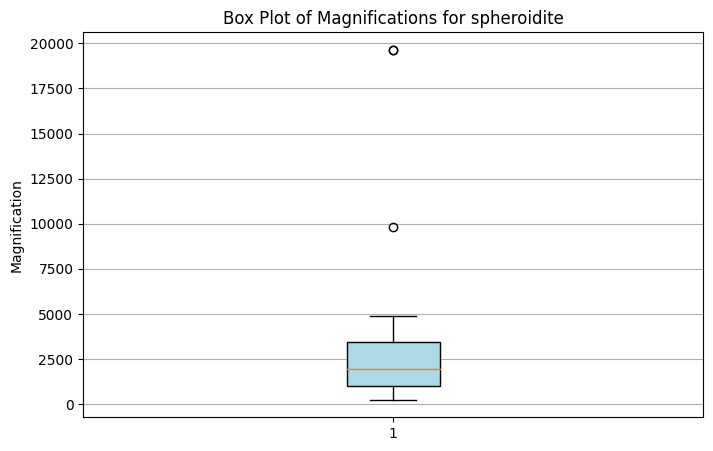

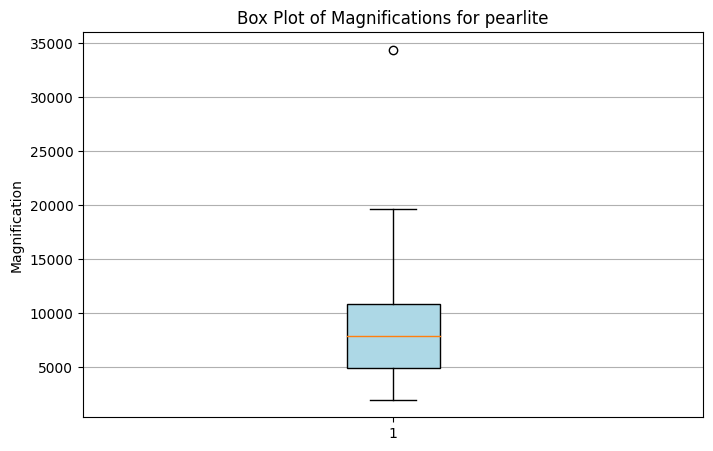

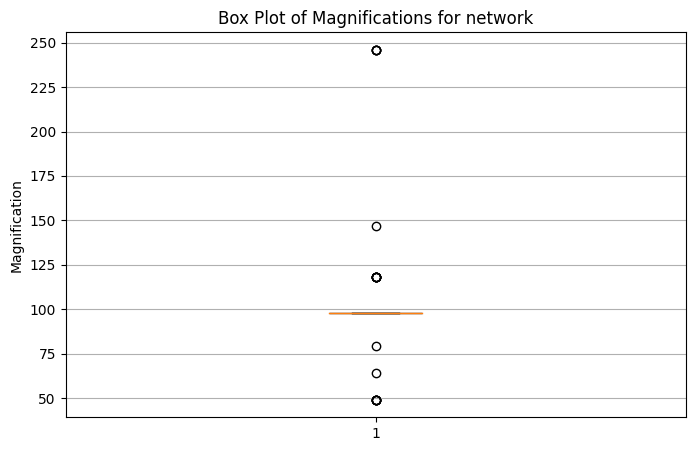

In [13]:

# Ensuring the magnification column is numeric and properly formatted
df_filtered["magnification"] = pd.to_numeric(df_filtered["magnification"], errors="coerce")

# Creating separate box plots for each primary_microconstituent
for microconstituent in df_filtered["primary_microconstituent"].unique():
    subset = df_filtered[df_filtered["primary_microconstituent"] == microconstituent]
    
    # Plotting box plot
    plt.figure(figsize=(8, 5))
    plt.boxplot(subset["magnification"].dropna(), vert=True, patch_artist=True, boxprops=dict(facecolor="lightblue"))
    
    # Labels and title
    plt.ylabel("Magnification")
    plt.title(f"Box Plot of Magnifications for {microconstituent}")
    plt.grid(axis="y")
    
    # Show plot
    plt.show()



In [14]:
# Function to compute IQR and remove outliers for each microconstituent group
def remove_outliers_grouped(df, column, groupby_column, iqr_multiplier=2.0):
    def remove_outliers(sub_df):
        Q1 = sub_df[column].quantile(0.25)
        Q3 = sub_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        return sub_df[(sub_df[column] >= lower_bound) & (sub_df[column] <= upper_bound)]
    
    return df.groupby(groupby_column, group_keys=False).apply(remove_outliers)

# Apply the function to remove outliers for each microconstituent
df_filtered = remove_outliers_grouped(df_filtered, "magnification", "primary_microconstituent", iqr_multiplier=2.0)


In [15]:
df_filtered.shape

(428, 6)

In [16]:
#drop column magnification
df_filtered.drop(columns=['magnification'],inplace=True)

In [17]:
#check unique values for cooling method
df_filtered['cool_method'].value_counts()

cool_method
Q         381
FC         30
AR         16
650-1H      1
Name: count, dtype: int64

In [18]:
#dropping cool_method 650-1H since there is only one entry 
df_filtered = df_filtered[df_filtered["cool_method"] != "650-1H"]

In [19]:
# Create an interactive scatter plot with Plotly
fig = px.scatter(
    df_filtered,
    x="anneal_time",
    y="anneal_temperature",
    color="primary_microconstituent",  # Color by microconstituent
    symbol="cool_method",  # Different symbols for cooling method
    hover_data=["path", "cool_method"],  # Show additional data on hover
    title="Interactive Scatter Plot: Anneal Time vs. Temperature",
    labels={"anneal_time": "Anneal Time (min)", "anneal_temperature": "Anneal Temperature (C)"}
)

# Show the interactive plot
fig.show()


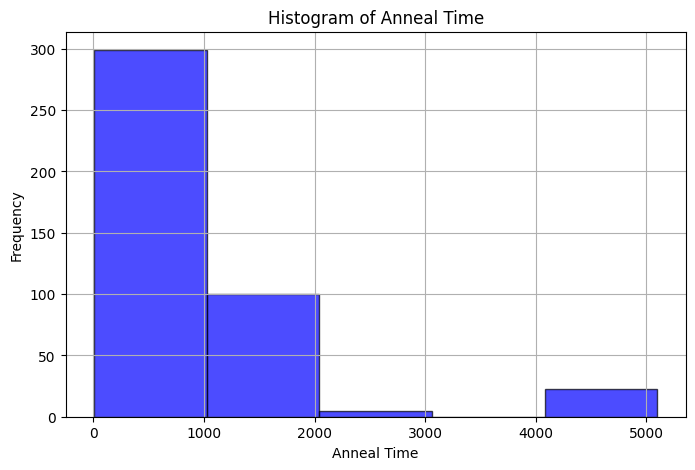

In [20]:
#Data needs to be normalized
# Plotting histogram for anneal_time
plt.figure(figsize=(8, 5))
plt.hist(df_filtered["anneal_time"], bins=5, alpha=0.7, color='blue', edgecolor='black')

plt.xlabel("Anneal Time")
plt.ylabel("Frequency")
plt.title("Histogram of Anneal Time")
plt.grid(True)
plt.show()

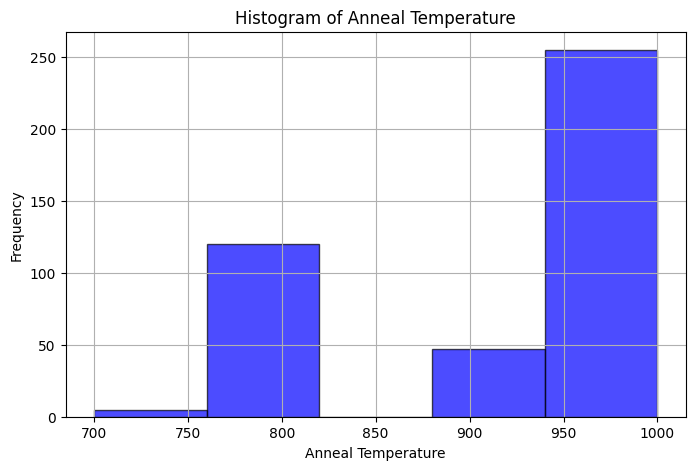

In [21]:
#data needs to be normalized
plt.figure(figsize=(8, 5))
plt.hist(df_filtered["anneal_temperature"], bins=5, alpha=0.7, color='blue', edgecolor='black')

plt.xlabel("Anneal Temperature")
plt.ylabel("Frequency")
plt.title("Histogram of Anneal Temperature")
plt.grid(True)
plt.show()

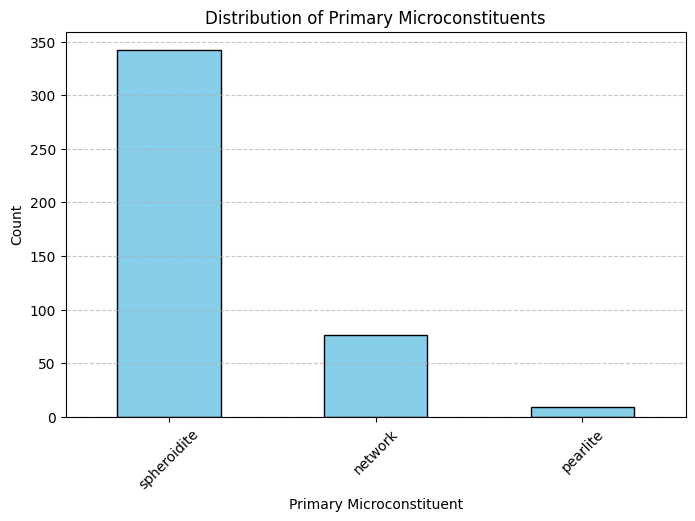

In [44]:

# Count occurrences of each microconstituent
microconstituent_counts = df_filtered["primary_microconstituent"].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 5))
microconstituent_counts.plot(kind="bar", color="skyblue", edgecolor="black")

# Labels and title
plt.xlabel("Primary Microconstituent")
plt.ylabel("Count")
plt.title("Distribution of Primary Microconstituents")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()


# Organizing train and test images

In [22]:
# Splitting the data into train and test set while maintaining the proportion of primary_microconstituent
df_train, df_test = train_test_split(df_filtered, test_size=0.3, stratify=df_filtered["primary_microconstituent"], random_state=42)

In [23]:
#Train images

# Define the base directory where the images are stored
source_folder = 'For Training/Cropped'  # Replace with the actual path to your image folder
destination_folder = "train_images"  # This is where categorized images will be saved

# Create destination directory if it doesn’t exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Loop through each row and move images to respective category folders
for index, row in df_train.iterrows():
    category = row['primary_microconstituent']  # Extract category name
    image_filename = 'Cropped' + row['path']  # Extract image filename
    
    # Create category folder if it does not exist
    category_path = os.path.join(destination_folder, category)
    if not os.path.exists(category_path):
        os.makedirs(category_path)

    # Define source and destination paths
    source_path = os.path.join(source_folder, image_filename)
    destination_path = os.path.join(category_path, image_filename)

    # Move the image to its category folder
    if os.path.exists(source_path):  # Ensure the file exists before moving
        shutil.copy(source_path, destination_path)
        print(f"Copied: {image_filename} -> {category_path}")
    else:
        print(f"Warning: {image_filename} not found in {source_folder}")

print("Image organization completed! 🎉")

Copied: Croppedmicrograph24.png -> train_images/network
Copied: Croppedmicrograph437.png -> train_images/spheroidite
Copied: Croppedmicrograph1257.png -> train_images/spheroidite
Copied: Croppedmicrograph1474.png -> train_images/spheroidite
Copied: Croppedmicrograph172.png -> train_images/spheroidite
Copied: Croppedmicrograph1056.png -> train_images/spheroidite
Copied: Croppedmicrograph894.png -> train_images/spheroidite
Copied: Croppedmicrograph524.png -> train_images/spheroidite
Copied: Croppedmicrograph76.png -> train_images/spheroidite
Copied: Croppedmicrograph398.png -> train_images/spheroidite
Copied: Croppedmicrograph1306.png -> train_images/spheroidite
Copied: Croppedmicrograph301.png -> train_images/network
Copied: Croppedmicrograph257.png -> train_images/spheroidite
Copied: Croppedmicrograph407.png -> train_images/spheroidite
Copied: Croppedmicrograph411.png -> train_images/spheroidite
Copied: Croppedmicrograph1456.png -> train_images/spheroidite
Copied: Croppedmicrograph569.

Copied: Croppedmicrograph659.png -> train_images/network
Copied: Croppedmicrograph9.png -> train_images/network
Copied: Croppedmicrograph689.png -> train_images/spheroidite
Copied: Croppedmicrograph1520.png -> train_images/spheroidite
Copied: Croppedmicrograph616.png -> train_images/spheroidite
Copied: Croppedmicrograph566.png -> train_images/spheroidite
Copied: Croppedmicrograph1693.png -> train_images/spheroidite
Copied: Croppedmicrograph1098.png -> train_images/spheroidite
Copied: Croppedmicrograph1150.png -> train_images/spheroidite
Copied: Croppedmicrograph1372.png -> train_images/spheroidite
Copied: Croppedmicrograph597.png -> train_images/network
Copied: Croppedmicrograph1569.png -> train_images/spheroidite
Copied: Croppedmicrograph841.png -> train_images/network
Copied: Croppedmicrograph936.png -> train_images/spheroidite
Copied: Croppedmicrograph1183.png -> train_images/spheroidite
Copied: Croppedmicrograph1176.png -> train_images/spheroidite
Copied: Croppedmicrograph1302.png 

In [24]:
#Test images

# Define the base directory where the images are stored
source_folder = 'For Training/Cropped'  # Replace with the actual path to your image folder
destination_folder = "test_images"  # This is where categorized images will be saved

# Create destination directory if it doesn’t exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Loop through each row and move images to respective category folders
for index, row in df_test.iterrows():
    category = row['primary_microconstituent']  # Extract category name
    image_filename = 'Cropped' + row['path']  # Extract image filename
    
    # Create category folder if it does not exist
    category_path = os.path.join(destination_folder, category)
    if not os.path.exists(category_path):
        os.makedirs(category_path)

    # Define source and destination paths
    source_path = os.path.join(source_folder, image_filename)
    destination_path = os.path.join(category_path, image_filename)

    # Move the image to its category folder
    if os.path.exists(source_path):  # Ensure the file exists before moving
        shutil.copy(source_path, destination_path)
        print(f"Copied: {image_filename} -> {category_path}")
    else:
        print(f"Warning: {image_filename} not found in {source_folder}")

print("Image organization completed! 🎉")

Copied: Croppedmicrograph1092.png -> test_images/spheroidite
Copied: Croppedmicrograph1273.png -> test_images/spheroidite
Copied: Croppedmicrograph1605.png -> test_images/pearlite
Copied: Croppedmicrograph1351.png -> test_images/network
Copied: Croppedmicrograph1483.png -> test_images/spheroidite
Copied: Croppedmicrograph1348.png -> test_images/spheroidite
Copied: Croppedmicrograph1507.png -> test_images/spheroidite
Copied: Croppedmicrograph1008.png -> test_images/spheroidite
Copied: Croppedmicrograph113.png -> test_images/network
Copied: Croppedmicrograph319.png -> test_images/spheroidite
Copied: Croppedmicrograph67.png -> test_images/spheroidite
Copied: Croppedmicrograph1161.png -> test_images/spheroidite
Copied: Croppedmicrograph1522.png -> test_images/spheroidite
Copied: Croppedmicrograph952.png -> test_images/spheroidite
Copied: Croppedmicrograph436.png -> test_images/spheroidite
Copied: Croppedmicrograph601.png -> test_images/spheroidite
Copied: Croppedmicrograph1359.png -> test_

In [25]:
#saving image path for training

BASE_DIR = 'train_images'
image_paths_train = []

# load image path to the list
for index, row in df_train.iterrows():
    category = row['primary_microconstituent']  # Extract category name
    image_filename = 'Cropped' + row['path']  # Extract image filename
    image_path = os.path.join(BASE_DIR,category,image_filename)
    image_paths_train.append(image_path)

In [26]:
#saving image path for test

BASE_DIR = 'test_images'
image_paths_test = []

# load image path to the list
for index, row in df_test.iterrows():
    category = row['primary_microconstituent']  # Extract category name
    image_filename = 'Cropped' + row['path']  # Extract image filename
    image_path = os.path.join(BASE_DIR,category,image_filename)
    image_paths_test.append(image_path)

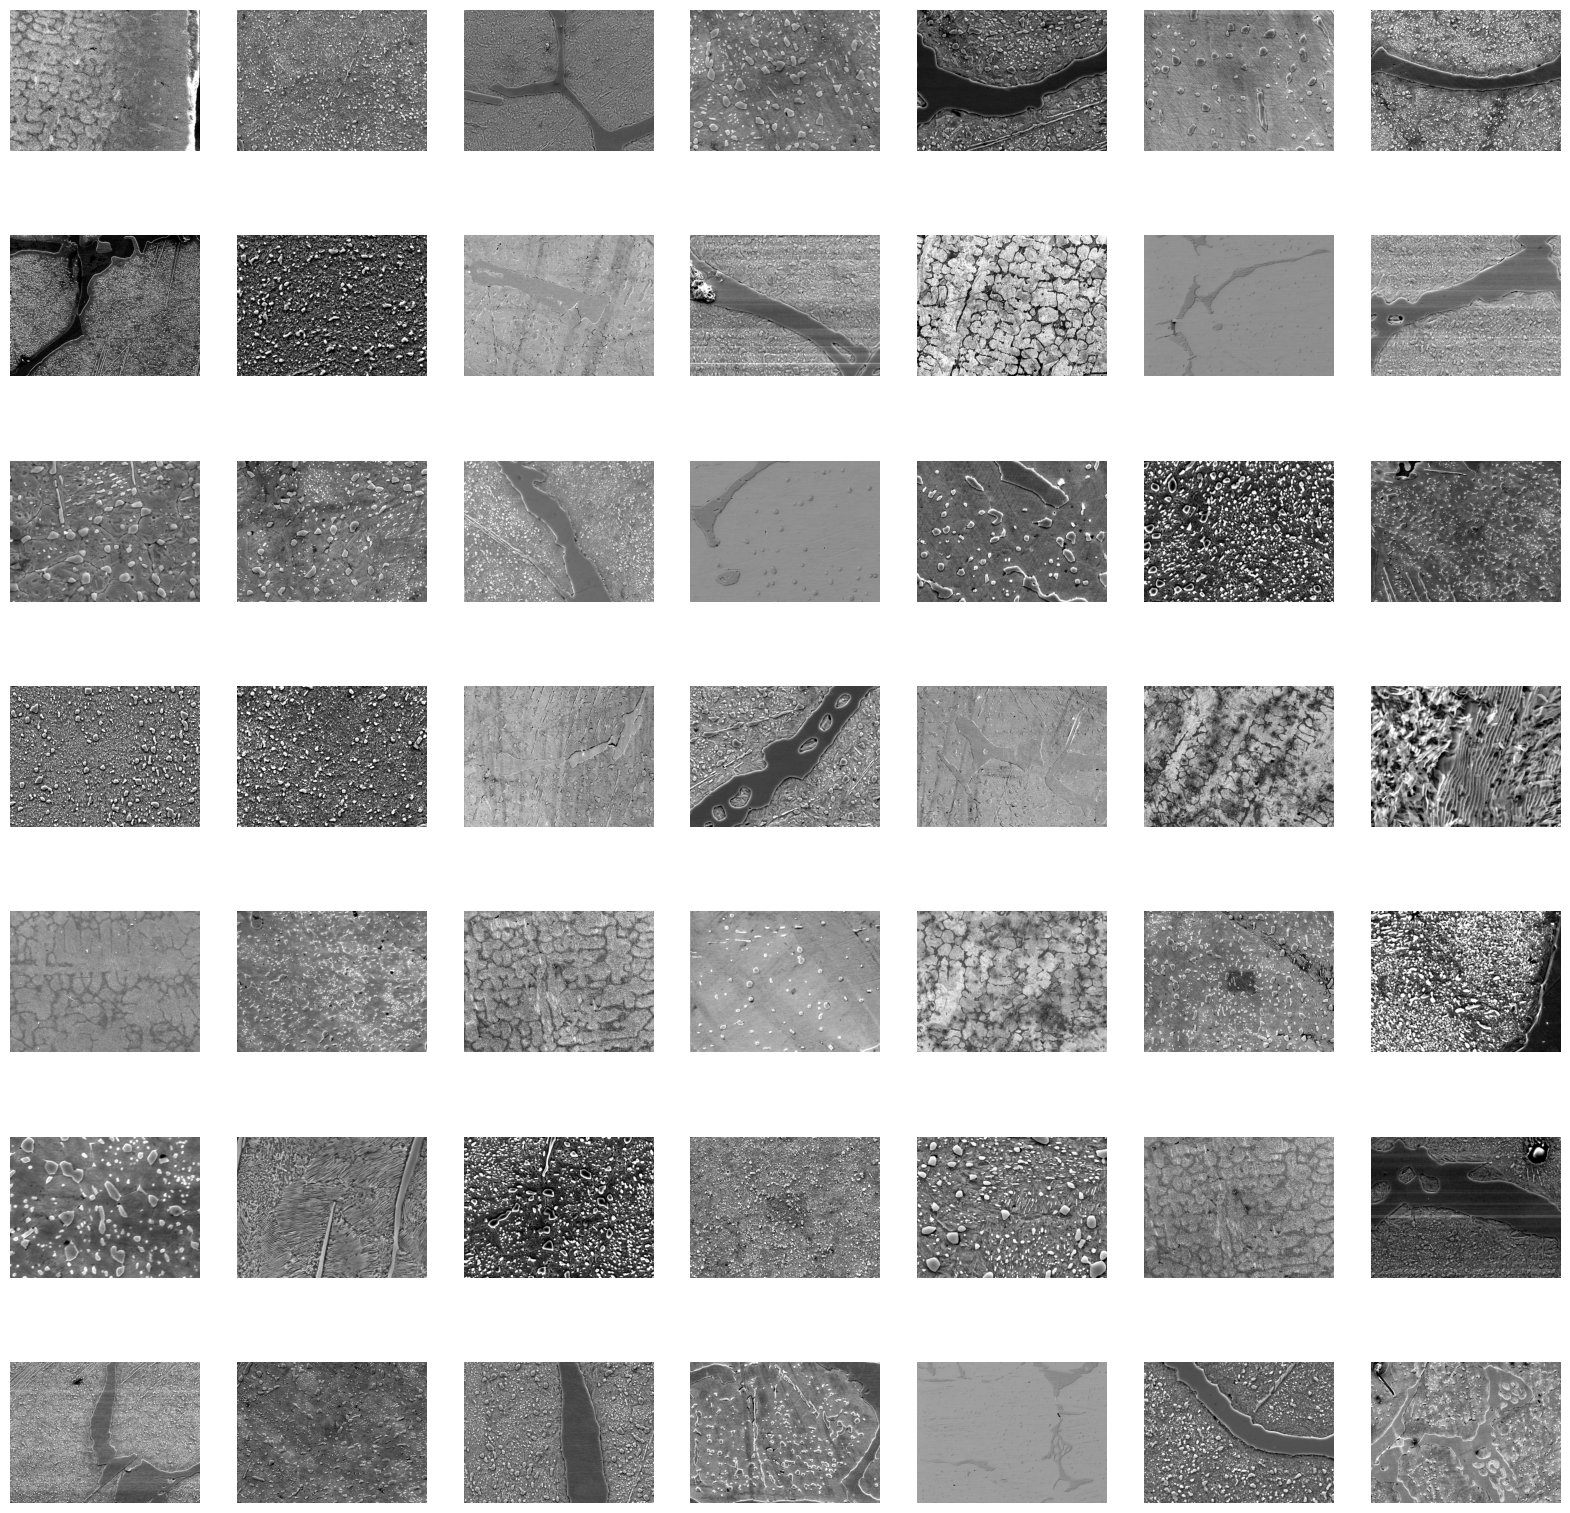

In [27]:
# To display grid of 10x10
plt.figure(figsize=(20,20))
temp_images = image_paths_train[:49]
index=1

for image_path in temp_images:
    plt.subplot(7,7,index)
    # Load the image
    img = load_img(image_path)
    # convert to numpy to array
    img = np.array(img)
    # show the image
    plt.imshow(img)
    plt.axis('off')
    # Increment the index for the next image 
    index +=1

# Functions

In [28]:
def load_and_preprocess_image(filename, BASE_DIR, category):
    # Build the full path by including the category directory
    image_path = os.path.join(BASE_DIR, category, 'Cropped' + filename)
    img = load_img(image_path, target_size=IMG_SIZE)  # Load and resize the image
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    return img_array

In [29]:
# Function to preprocess numerical features
def preprocess_numerical_features(df_train, df_test):
    scaler = StandardScaler()
    train_numerical_features = scaler.fit_transform(df_train[["anneal_temperature", "anneal_time"]])
    test_numerical_features = scaler.transform(df_test[["anneal_temperature", "anneal_time"]])
    return train_numerical_features, test_numerical_features


In [30]:
# Function to preprocess categorical features
def preprocess_categorical_features(df_train, df_test):
    encoder = OneHotEncoder(sparse_output=False)
    train_categorical_features = encoder.fit_transform(df_train[["cool_method"]])
    test_categorical_features = encoder.transform(df_test[["cool_method"]])
    return train_categorical_features, test_categorical_features, encoder

train_categorical_features, test_categorical_features, encoder = preprocess_categorical_features(df_train, df_test)

In [31]:
# Function to encode target labels
def encode_target_labels(df_train):
    target_encoder = OneHotEncoder(sparse_output=False)
    train_target_labels = target_encoder.fit_transform(df_train[["primary_microconstituent"]])
    return train_target_labels, target_encoder

train_target_labels, target_encoder = encode_target_labels(df_train)

In [32]:
# Function to define data augmentation for images
def get_data_augmentation():
    return tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    ])

In [33]:
# Function to build CNN for image processing
def build_image_model(img_size, num_channels):
    image_input = Input(shape=(img_size[0], img_size[1], num_channels))
    
    augmented = get_data_augmentation()(image_input)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(augmented)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    image_branch = layers.Dense(128, activation='relu')(x)
    
    return models.Model(inputs=image_input, outputs=image_branch)

In [34]:
# Function to build the fully connected network for tabular data
def build_tabular_model(input_shape):
    tabular_input = Input(shape=(input_shape,))
    y = layers.Dense(64, activation='relu')(tabular_input)
    y = layers.Dense(32, activation='relu')(y)
    tabular_branch = layers.Dense(16, activation='relu')(y)
    
    return models.Model(inputs=tabular_input, outputs=tabular_branch)

In [35]:
# Function to build the full multimodal model
def build_combined_model(img_size, num_channels, tabular_input_shape, output_shape):
    image_model = build_image_model(img_size, num_channels)
    tabular_model = build_tabular_model(tabular_input_shape)

    merged = layers.concatenate([image_model.output, tabular_model.output])
    output = layers.Dense(output_shape, activation='softmax')(merged)

    return models.Model(inputs=[image_model.input, tabular_model.input], outputs=output)


In [36]:
# Function to compile and train the model
def train_model(model, train_image_data, train_numerical_features, train_categorical_features, train_target_labels):
    adam = Adam(learning_rate=0.001)

    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        [train_image_data, np.hstack((train_numerical_features, train_categorical_features))],
        train_target_labels,
        epochs=50,
        batch_size=8,
        validation_split=0.3,
        callbacks=[early_stop]
    )
    return history

# Model implementation

In [37]:
# Define image dimensions
IMG_SIZE = (128, 128)  # Resize images to 128x128
NUM_CHANNELS = 3       # RGB images


train_image_data = np.array([
    load_and_preprocess_image(row['path'], 'train_images', row['primary_microconstituent'])
    for _, row in df_train.iterrows()
])
test_image_data = np.array([
    load_and_preprocess_image(row['path'], 'test_images', row['primary_microconstituent'])
    for _, row in df_test.iterrows()
])


In [38]:
warnings.filterwarnings("ignore")

# df_train, df_test, train_image_data, and IMG_SIZE, NUM_CHANNELS are defined
train_numerical_features, test_numerical_features = preprocess_numerical_features(df_train, df_test)
train_categorical_features, test_categorical_features, encoder = preprocess_categorical_features(df_train, df_test)
train_target_labels, target_encoder = encode_target_labels(df_train)

# Define input shapes
tabular_input_shape = train_numerical_features.shape[1] + train_categorical_features.shape[1]
output_shape = train_target_labels.shape[1]

# Build and train the model
model = build_combined_model(IMG_SIZE, NUM_CHANNELS, tabular_input_shape, output_shape)
history = train_model(model, train_image_data, train_numerical_features, train_categorical_features, train_target_labels)

2025-03-04 16:14:11.172201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
26/26 [==============================] - 3s 44ms/step - loss: 0.7184 - accuracy: 0.7452 - val_loss: 0.5507 - val_accuracy: 0.8222
Epoch 2/50
26/26 [==============================] - 1s 36ms/step - loss: 0.6217 - accuracy: 0.7933 - val_loss: 0.5265 - val_accuracy: 0.8222
Epoch 3/50
26/26 [==============================] - 1s 36ms/step - loss: 0.5856 - accuracy: 0.7933 - val_loss: 0.5047 - val_accuracy: 0.8222
Epoch 4/50
26/26 [==============================] - 1s 34ms/step - loss: 0.5947 - accuracy: 0.7933 - val_loss: 0.4950 - val_accuracy: 0.8222
Epoch 5/50
26/26 [==============================] - 1s 34ms/step - loss: 0.5799 - accuracy: 0.7933 - val_loss: 0.4628 - val_accuracy: 0.8222
Epoch 6/50
26/26 [==============================] - 1s 34ms/step - loss: 0.5344 - accuracy: 0.7933 - val_loss: 0.4409 - val_accuracy: 0.8222
Epoch 7/50
26/26 [==============================] - 1s 34ms/step - loss: 0.5231 - accuracy: 0.7933 - val_loss: 1.2586 - val_accuracy: 0.8222
Epoch 8/50
26

# Model testing

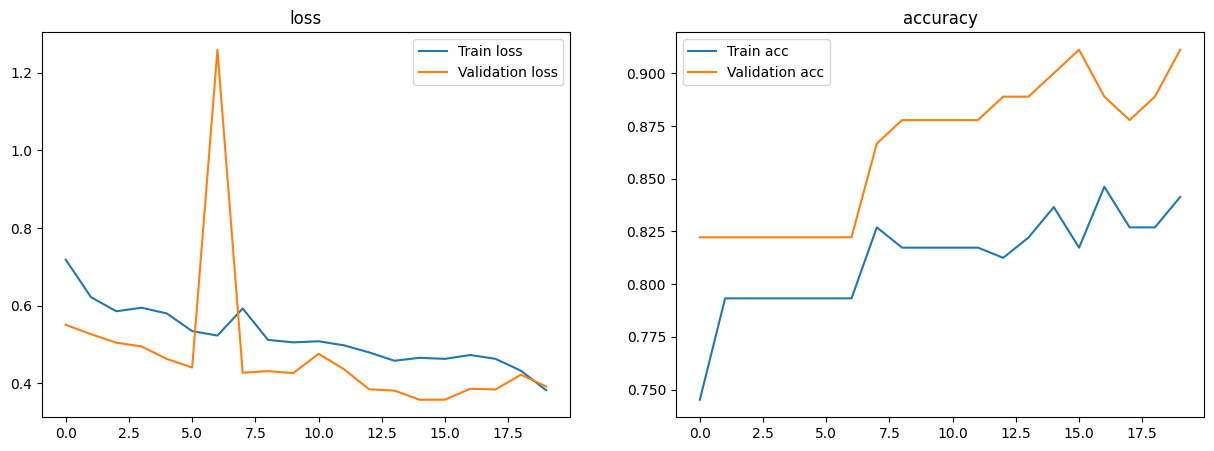

In [39]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
    
plot_history(history)

In [40]:
pred = model.predict([test_image_data, np.hstack((test_numerical_features, test_categorical_features))])

# Convert softmax output to actual class labels
predicted_labels = target_encoder.inverse_transform(pred)

5/5 [==============================] - 0s 23ms/step


In [41]:
true_labels_array = df_test["primary_microconstituent"].to_numpy()



✨ Model Evaluation Results ✨
✅ Accuracy: 0.8140



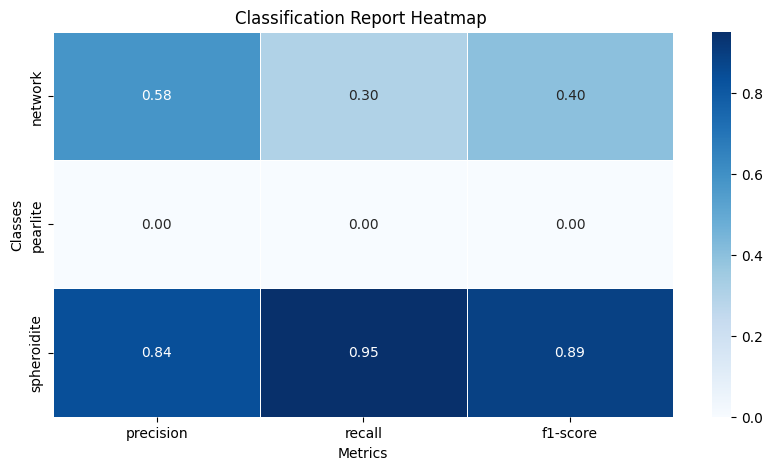

In [42]:
# Compute accuracy
accuracy = accuracy_score(true_labels_array, predicted_labels)

# Generate classification report as dictionary
report_dict = classification_report(true_labels_array, predicted_labels, output_dict=True)

# Convert classification report to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Remove "accuracy" and "macro avg" from the DataFrame
report_df_filtered = report_df.drop(["accuracy", "macro avg"], errors="ignore")

# Display accuracy
print(f"\n✨ Model Evaluation Results ✨")
print(f"✅ Accuracy: {accuracy:.4f}\n")

# Plot the heatmap without "accuracy" and "macro avg"
plt.figure(figsize=(10, 5))
sns.heatmap(report_df_filtered.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues", linewidths=0.5)
plt.title("Classification Report Heatmap ")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()
